In [4]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os

sys.path.append("/data/igor/loss_traces")

In [4]:
from results.result_processing import get_trace_reduction
from results.utils import (
    make_precision_recall_at_k_df,
    get_precision_at_fpr,
    make_precision_recall_at_k_df_single_threshold,
)
from results.final_model_metrics import get_final_model_metrics
from attacks import AttackConfig, LiRAAttack
from sklearn.metrics import roc_curve
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt

In [5]:
def positives_at_fpr(results, target_fpr=0.001):
    fpr, tpr, thresholds = roc_curve(
        results["target_trained_on"], results["lira_score"]
    )

    closest_idx = np.argmin(np.abs(fpr - target_fpr))
    threshold = thresholds[closest_idx]

    positives_at_threshold = np.sum(
        (results["lira_score"] >= threshold) & (results["target_trained_on"])
    )

    return positives_at_threshold

In [10]:
target_id = "target"
attack = "LiRA"
augment = True
batchsize = 32
num_workers = 8
gpu = ":1"

# all_results = {}
all_attacks = {}

for dataset in ("CIFAR10", "CIFAR100", "CINIC10"):
    for arch in ("wrn28-2", "wrn40-4", "rn-20"):
        if dataset != "CIFAR10" and arch != "wrn28-2":
            continue

        exp_id = f"{arch}_{dataset}"
        print(f"Architecture: {arch}, Dataset: {dataset}")
        config = AttackConfig(
            exp_id=exp_id,
            target_id=target_id,
            checkpoint=None,
            arch=arch,
            dataset=dataset,
            attack=attack,
            augment=augment,
            batchsize=batchsize,
            num_workers=num_workers,
            gpu=gpu,
        )
        attack = LiRAAttack(config)
        # results = attack.run()

        # num_positives_at_threshold = positives_at_fpr(results)
        # total_positives = results["target_trained_on"].sum()

        # max_recalls = []
        # for k in (1, 3, 5, 10):
        #     predicted_samples = k * total_positives // 100
        #     max_recalls.append(predicted_samples / num_positives_at_threshold)

        # print("------------------------------")
        # print(f"For {arch} on {dataset}:")
        # print(f"Total positives: {total_positives}")
        # print(f"Positives at threshold: {num_positives_at_threshold}")
        # print("Maximum possible recalls for different sample sizes:")
        # print(
        #     "\n".join(f"  {k}%: {r:.3f}" for k, r in zip([1, 3, 5, 10], max_recalls)),
        #     end="\n\n",
        # )
        # print("------------------------------")

        # all_results[(arch, dataset)] = results
        all_attacks[(arch, dataset)] = attack

Architecture: wrn28-2, Dataset: CIFAR10
Architecture: wrn40-4, Dataset: CIFAR10
Architecture: rn-20, Dataset: CIFAR10
Architecture: wrn28-2, Dataset: CIFAR100
Architecture: wrn28-2, Dataset: CINIC10


In [11]:
with open("all_results.pkl", "rb") as f:
    all_results = pickle.load(f)


In [7]:
# target_id = "target"
# attack = "LiRA"
# augment = True
# batchsize = 256
# num_workers = 8
# gpu = ":0"
# dataset = "CIFAR10"
# arch = "wrn28-2"
# exp_id = f"{arch}_{dataset}"

# config = AttackConfig(
#     exp_id=exp_id,
#     target_id=target_id,
#     checkpoint=None,
#     arch=arch,
#     dataset=dataset,
#     attack=attack,
#     augment=augment,
#     batchsize=batchsize,
#     num_workers=num_workers,
#     gpu=gpu,
# )
# attack = LiRAAttack(config)

In [8]:
# attack.compute_intermediate_results()

In [24]:
dataset = "CIFAR10"
arch = "wrn28-2"
exp_id = f"{arch}_{dataset}"

results = all_results[(arch, dataset)]
attack = all_attacks[(arch, dataset)]


In [46]:
all_results[(arch, dataset)]

,lira_score,target_trained_on
og_idx,,
0,1.575811e+00,True
1,1.287784e+00,True
2,9.335108e-01,False
3,1.645003e+00,True
4,1.167138e+00,False
...,...,...
49995,8.320430e-09,False
49996,7.083632e-03,False
49997,7.551377e+00,True


In [61]:
df_final_model_metrics = get_final_model_metrics(
    model=attack.model, data_loader=attack.attack_loaders[0], metrics=["loss"]
)
df_final_model_metrics = pd.merge(df_final_model_metrics, results, left_index=True, right_index=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:09<00:00, 162.95it/s]


In [1]:
df_final_model_metrics.to_csv("final_model_metrics.csv", index=True)

NameError: name 'df_final_model_metrics' is not defined

In [60]:
attack.run()

RESULTS EXIST BUT NOT OVERWRITING


Attack AUC: 0.7406980464


,lira_score,target_trained_on
og_idx,,
0,1.575805e+00,True
1,1.287782e+00,True
2,9.335236e-01,False
3,1.645038e+00,True
4,1.167192e+00,False
...,...,...
49995,8.327365e-09,False
49996,7.044658e-03,False
49997,7.556936e+00,True


In [58]:
df_final_model_metrics

,loss,confidence,lira_score,target_trained_on
0,3.060943,1.908876,1.575811e+00,True
1,1.320183,0.375180,1.287784e+00,True
2,0.947131,0.880273,9.335108e-01,False
3,2.784540,1.220581,1.645003e+00,True
4,3.237259,0.339873,1.167138e+00,False
...,...,...,...,...
49995,3.126124,0.082679,8.320430e-09,False
49996,4.326099,4.247805,7.083632e-03,False
49997,1.136940,0.494208,7.551377e+00,True
49998,3.533194,0.590331,1.004149e+00,True


In [112]:
make_precision_recall_at_k_df_single_threshold(
    scores_df = df_final_model_metrics,
    ground_truth_df=results,
    fpr_threshold=0.001,
    k_frac=0.01,
)

{'spearman_loss': 0.16361210539374452,
 'spearman_confidence': 0.17586292244301246,
 'spearman_lira_score': 1.0,
 'fpr': 0.00104,
 'tpr': 0.09744,
 'positives': 2436,
 'precision_random_guess': 0.09744,
 'recall_random_guess': 0.01,
 'overlap_loss_desc': 52,
 'precision_loss_desc': 0.208,
 'recall_loss_desc': 0.021346469622331693,
 'overlap_loss_asc': 5,
 'precision_loss_asc': 0.02,
 'recall_loss_asc': 0.002052545155993432,
 'overlap_confidence_desc': 5,
 'precision_confidence_desc': 0.02,
 'recall_confidence_desc': 0.002052545155993432,
 'overlap_confidence_asc': 50,
 'precision_confidence_asc': 0.2,
 'recall_confidence_asc': 0.020525451559934318,
 'overlap_lira_score_desc': 250,
 'precision_lira_score_desc': 1.0,
 'recall_lira_score_desc': 0.10262725779967159,
 'overlap_lira_score_asc': 0,
 'precision_lira_score_asc': 0.0,
 'recall_lira_score_asc': 0.0}

In [ ]:
keys = [
    
]

In [ ]:
# df_final_model_metrics.to_csv("final_model_metrics_wrn28_cifar10.csv", index=True)

In [50]:
with open("all_results.pkl", "wb") as f:
    pickle.dump(all_results, f)


In [113]:
make_precision_recall_at_k_df_single_threshold(
    scores_df = trace_df,
    ground_truth_df=results,
    fpr_threshold=0.001,
    k_frac=0.01,
)

{'spearman_trace_value': 0.6156185077842038,
 'fpr': 0.00104,
 'tpr': 0.09744,
 'positives': 2436,
 'precision_random_guess': 0.09744,
 'recall_random_guess': 0.01,
 'overlap_trace_value_desc': 230,
 'precision_trace_value_desc': 0.92,
 'recall_trace_value_desc': 0.09441707717569786,
 'overlap_trace_value_asc': 0,
 'precision_trace_value_asc': 0.0,
 'recall_trace_value_asc': 0.0}

In [102]:
df[df["target_trained_on"]]["loss"]

0        2.515284e-05
1        7.152555e-07
3        4.315283e-05
5        1.049036e-05
8        3.123235e-05
             ...     
49990    1.212285e-04
49993    7.033324e-06
49997    5.236481e-03
49998    1.103817e-04
49999    1.193214e-04
Name: loss, Length: 25000, dtype: float64

Spearman correlation between trace values and LIRA scores: -0.164


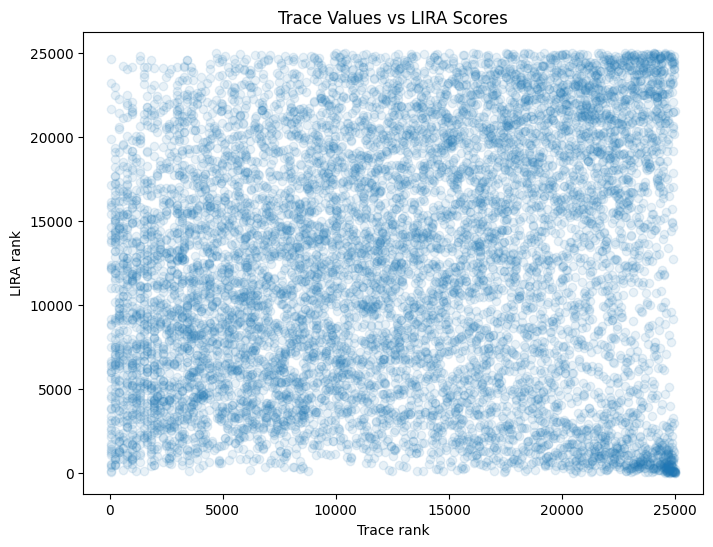

In [ ]:
df = df_final_model_metrics
col = "loss"

# Compute Spearman's rank correlation between trace values and LIRA scores
correlation = df[df["target_trained_on"]][col].corr(
    results[results["target_trained_on"]]["lira_score"], method="spearman"
)


print(f"Spearman correlation between trace values and LIRA scores: {correlation:.3f}")
# Create a scatter plot of trace values vs LIRA scores
plt.figure(figsize=(8, 6))
plt.scatter(
    df[df["target_trained_on"]][col]
    .rank()
    .sample(n=10000, random_state=42),
    df[df["target_trained_on"]]["lira_score"]
    .rank()
    .sample(n=10000, random_state=42),
    alpha=0.1,
)
plt.xlabel("Trace rank")
plt.ylabel("LIRA rank")
plt.title("Trace Values vs LIRA Scores")
# plt.ylim(0, 1000)
# plt.xlim(45000,50000)
plt.show()


Spearman correlation between trace values and LIRA scores: 0.616


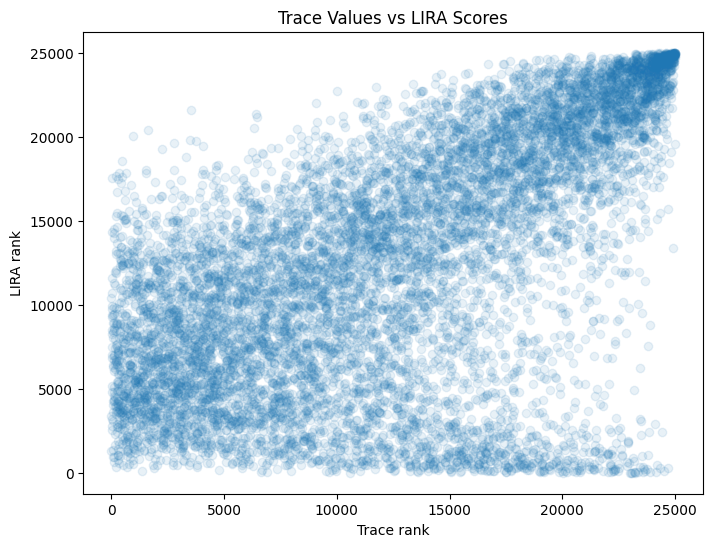

In [95]:
# Compute Spearman's rank correlation between trace values and LIRA scores
correlation = trace_df[trace_df["target_trained_on"]]["trace_value"].corr(
    results[results["target_trained_on"]]["lira_score"], method="spearman"
)


print(f"Spearman correlation between trace values and LIRA scores: {correlation:.3f}")
# Create a scatter plot of trace values vs LIRA scores
plt.figure(figsize=(8, 6))
plt.scatter(
    trace_df[trace_df["target_trained_on"]]["trace_value"]
    .rank()
    .sample(n=10000, random_state=42),
    results[results["target_trained_on"]]["lira_score"]
    .rank()
    .sample(n=10000, random_state=42),
    alpha=0.1,
)
plt.xlabel("Trace rank")
plt.ylabel("LIRA rank")
plt.title("Trace Values vs LIRA Scores")
# plt.ylim(0, 1000)
# plt.xlim(45000,50000)
plt.show()


In [85]:
trace_df["trace_value"]

og_idx
0        0.037929
1        0.000241
2        0.179490
3        0.003998
4        0.000282
           ...   
49995    2.071802
49996    1.052571
49997    0.675529
49998    0.000269
49999    0.765588
Name: trace_value, Length: 50000, dtype: float64

In [84]:
trace_df["trace_value"].rank()

og_idx
0        23541.0
1         3939.0
2        32145.0
3        12715.0
4         4271.0
          ...   
49995    46696.0
49996    42688.0
49997    39911.0
49998     4159.0
49999    40690.0
Name: trace_value, Length: 50000, dtype: float64

In [33]:
make_precision_recall_at_k_df_single_threshold(
    scores_df = trace_df,
    ground_truth_df=results,
    fpr_threshold=0.001,
    k_frac=0.01,
)

{'fpr': 0.00104,
 'tpr': 0.09744,
 'positives': 2436,
 'precision_random_guess': 0.09744,
 'recall_random_guess': 0.01,
 'overlap_trace_value_desc': 230,
 'precision_trace_value_desc': 0.92,
 'recall_trace_value_desc': 0.09441707717569786,
 'overlap_trace_value_asc': 0,
 'precision_trace_value_asc': 0.0,
 'recall_trace_value_asc': 0.0}

In [36]:
make_precision_recall_at_k_df_single_threshold(
    scores_df = df_final_model_metrics,
    ground_truth_df=results,
    fpr_threshold=0.001,
    k_frac=0.01,
)

{'fpr': 0.00104,
 'tpr': 0.09744,
 'positives': 2436,
 'precision_random_guess': 0.09744,
 'recall_random_guess': 0.01,
 'overlap_loss_desc': 19,
 'precision_loss_desc': 0.076,
 'recall_loss_desc': 0.007799671592775041,
 'overlap_loss_asc': 16,
 'precision_loss_asc': 0.064,
 'recall_loss_asc': 0.006568144499178982,
 'overlap_confidence_desc': 27,
 'precision_confidence_desc': 0.108,
 'recall_confidence_desc': 0.011083743842364532,
 'overlap_confidence_asc': 19,
 'precision_confidence_asc': 0.076,
 'recall_confidence_asc': 0.007799671592775041,
 'overlap_param_grad_norm_desc': 20,
 'precision_param_grad_norm_desc': 0.08,
 'recall_param_grad_norm_desc': 0.008210180623973728,
 'overlap_param_grad_norm_asc': 27,
 'precision_param_grad_norm_asc': 0.108,
 'recall_param_grad_norm_asc': 0.011083743842364532,
 'overlap_param_grad_var_desc': 21,
 'precision_param_grad_var_desc': 0.084,
 'recall_param_grad_var_desc': 0.008620689655172414,
 'overlap_param_grad_var_asc': 27,
 'precision_param_grad_

In [29]:
df

,loss,confidence
0,0.000023,21.484066
1,0.000122,18.315231
2,0.000019,22.002975
3,0.000003,25.348915
4,0.000061,20.398060
...,...,...
89995,0.105765,4.389452
89996,0.000008,23.452702
89997,0.000247,16.645596
89998,0.000680,15.236523


Total positive samples: 25000
Positive samples at FPR=0.001 (threshold=28.020): 2435


In [2]:
trace = get_trace_reduction(exp_id, reduction="iqr")

NameError: name 'get_trace_reduction' is not defined

In [48]:
trace

0        0.037929
1        0.000241
2        0.179490
3        0.003998
4        0.000282
           ...   
49995    2.071802
49996    1.052571
49997    0.675529
49998    0.000269
49999    0.765588
Length: 50000, dtype: float64

In [27]:
# Convert trace Series to DataFrame
trace_df = pd.DataFrame({'trace_value': trace})

# Merge with target_trained_on from results
# First reset index on results to get og_idx as a column
results_reset = results.reset_index()

# Now merge the dataframes on index
trace_df = trace_df.reset_index()
trace_df = pd.merge(trace_df, results_reset[['og_idx', 'target_trained_on']],
                   left_on='index', right_on='og_idx', how='left')

# Clean up the dataframe
trace_df = trace_df.drop(['index', 'og_idx'], axis=1)
trace_df = trace_df.set_index(results_reset['og_idx'])

# Display the first few rows
trace_df


,trace_value,target_trained_on
og_idx,,
0,0.037929,True
1,0.000241,True
2,0.179490,False
3,0.003998,True
4,0.000282,False
...,...,...
49995,2.071802,False
49996,1.052571,False
49997,0.675529,True


In [16]:
# df = make_precision_recall_at_k_df(trace_df, results, k_frac=1.0)

31440it [07:31, 69.58it/s]


In [17]:
get_precision_at_fpr(df, fpr=0.001)

{'fpr': np.float64(0.0010222222222222223),
 'tpr': np.float64(0.12917777777777778),
 'positives': np.float64(5813.0),
 'precision_random_guess': np.float64(0.12917777777777778),
 'recall_random_guess': np.float64(1.0),
 'overlap_trace_value_desc': np.float64(5813.0),
 'precision_trace_value_desc': np.float64(0.12917777777777778),
 'recall_trace_value_desc': np.float64(1.0),
 'overlap_trace_value_asc': np.float64(5813.0),
 'precision_trace_value_asc': np.float64(0.12917777777777778),
 'recall_trace_value_asc': np.float64(1.0)}

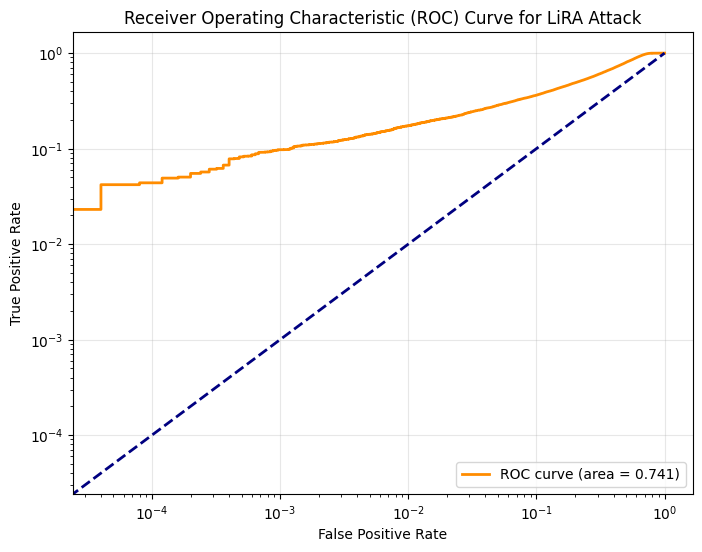

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Extract the ground truth (target_trained_on) and scores (lira_score)
y_true = results["target_trained_on"]
y_scores = results["lira_score"]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve for LiRA Attack")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.xscale("log")
plt.yscale("log")
plt.show()
